# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- [ ] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [ ] Использовать CrossEntropyLoss и L2-регуляризацию.
- [ ] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [ ] (**+2 балла**) Добавить Batch normalization.
- [ ] (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [ ] (**+1 балл**) Также реализовать оптимизатор Adam.


In [2]:
import os
import random
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import itertools
from torch.optim import Optimizer
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchinfo
from torch.utils.data import Subset
import torchvision.io as io
import torchvision.datasets as datasets
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

amdgpu.ids: No such file or directory


In [3]:
# print("CUDA available:", torch.cuda.is_available())
# print("Device count:", torch.cuda.device_count())
# print("Current device:", torch.cuda.current_device())
# print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
device = "cpu"
torch.set_num_threads(12)

### Dataset
English Handwritten Characters

3.4k images of handwritten English characters

This dataset contains 3,410 images of handwritten characters in English. This is a classification dataset that can be used for Computer Vision tasks. It contains 62 classes with 55 images of each class. The 62 classes are 0-9, A-Z and a-z.


In [9]:
dataset_path = kagglehub.dataset_download(
    "dhruvildave/english-handwritten-characters-dataset"
)
csv_file_path = os.path.join(dataset_path, "english.csv")
df = pd.read_csv(csv_file_path)
df.columns = ["path", "class"]
df["path"] = df["path"].apply(lambda x: os.path.join(dataset_path, x))

Отфильтруем строчные буквы, чтобы уменьшить количество классов

In [10]:
df = df[df["class"].str.match(r"^[0-9]$|^[A-Z]$")]
# df = df[df["class"].str.match(r"^[0-9]$")]

In [11]:
df.describe()

,path,class
count,1980,1980
unique,1980,36
top,/home/artemkhel/.cache/kagglehub/datasets/dhruvi...,0
freq,1,55


In [12]:
df["class"].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype=object)

In [13]:
train_set, remaining = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["class"]
)
val_set, test_set = train_test_split(
    remaining, test_size=0.25, random_state=42, stratify=remaining["class"]
)
train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)
train_set.describe()

,path,class
count,1584,1584
unique,1584,36
top,/home/artemkhel/.cache/kagglehub/datasets/dhruvi...,F
freq,1,44


In [27]:
class_to_idx = {cls: idx for idx, cls in enumerate(df["class"].unique())}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}


class MyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["path"]
        label = class_to_idx[(self.dataframe.iloc[idx]["class"])]

        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label


image_size = 32
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(),
        transforms.RandomInvert(1),
    ]
)

train_dataset = MyDataset(train_set, transform=transform)
val_dataset = MyDataset(val_set, transform=transform)
test_dataset = MyDataset(test_set, transform=transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

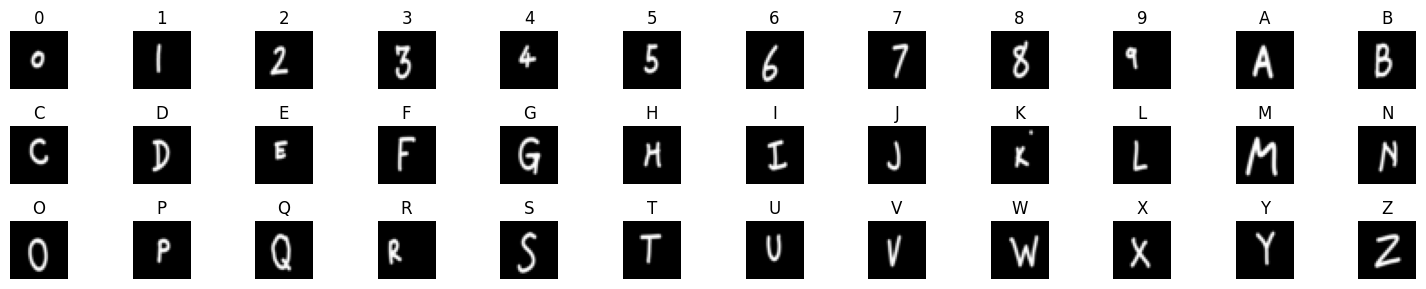

In [28]:
def show_random(dataset):
    df = dataset.dataframe

    unique_classes = df["class"].unique()
    unique_classes.sort()
    num_classes = len(unique_classes)

    num_rows = 3
    num_cols = (num_classes + num_rows - 1) // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 1 * num_rows))
    axes = axes.flatten()

    to_img = transforms.ToPILImage()
    for ax, class_label in zip(axes, unique_classes):
        class_indices = df[df["class"] == class_label].index.tolist()
        random_index = random.choice(class_indices)
        image, label = dataset[random_index]

        ax.imshow(to_img(image), cmap="gray")
        ax.set_title(idx_to_class[label])
        ax.axis("off")

    for ax in axes[num_classes:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_random(train_dataset)
# show_random(val_dataset)
# show_random(test_dataset)

### Слои и нейронная сеть

In [19]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * torch.sqrt(torch.tensor(2.0 / in_features)))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        self.x = x
        return x @ self.weight + self.bias

    def backward(self, grad_output):
        grad_input = grad_output @ self.weights.t()
        self.weights.grad = self.x.t() @ grad_output
        self.bias.grad = grad_output.sum(dim=0)
        return grad_input


class ReluLayer(nn.Module):
    def forward(self, x):
        self.x = x
        return F.relu(x)

    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input[self.x <= 0] = 0
        return grad_input


class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, batch_normalization=False):
        super().__init__()
        self.batch_normalization = batch_normalization

        self.fc1 = FullyConnectedLayer(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) if self.batch_normalization else None
        self.relu1 = ReluLayer()
        self.fc2 = FullyConnectedLayer(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        if self.batch_normalization:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

### Оптимизатор Adam

In [21]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if eps < 0.0:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        if closure is not None:
            closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)

                state['step'] += 1
                m, v = state['m'], state['v']

                m.mul_(group['betas'][0]).add_(grad, alpha=1 - group['betas'][0])
                v.mul_(group['betas'][1]).addcmul_(grad, grad, value=1 - group['betas'][1])

                m_hat = m / (1 - group['betas'][0] ** state['step'])
                v_hat = v / (1 - group['betas'][1] ** state['step'])

                p.data.addcdiv_(m_hat, v_hat.sqrt().add_(group['eps']), value=-group['lr'])

        return

In [25]:
class Trainer:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        test_loader,
        num_epochs=10,
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs

    def train(self):
        train_loss = []
        val_loss = []
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0

            for images, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(self.train_loader)
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {avg_loss:.4f}")

            train_loss.append(avg_loss)
            avg_val_loss = self.validate()
            val_loss.append(avg_val_loss)

        print(train_loss, val_loss)
        return train_loss, val_loss


    @torch.no_grad()
    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        for images, labels in self.val_loader:
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(self.val_loader)
        accuracy = 100 * correct / total
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
        return avg_val_loss

    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Accuracy of the model on the test set: {100 * accuracy:.2f}%")
        return accuracy

In [30]:
input_size = image_size * image_size
num_classes = len(train_dataset.dataframe["class"].unique())

# model = SimpleNN(input_size, num_classes, hidden_size=64)  # .to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=0.001)
# print(f"Random guess: {100 / df['class'].nunique():.2f}%")
# trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=5)
# trainer.train()
# trainer.evaluate()

### Подбор параметров

In [92]:
class HPGrid:
    def __init__(self):
        self.epochs = [10]
        self.optimizers = [
            ("RMSprop", optim.RMSprop),
            ("Adam", Adam),
        ]
        self.learning_rates = [0.01, 0.001]
        self.hidden_sizes = [128, 256]
        self.batch_norm_options = [False, True]

    def generate_configs(self):
        return list(itertools.product(
            self.epochs,
            self.optimizers,
            self.learning_rates,
            self.hidden_sizes,
            self.batch_norm_options
        ))

In [95]:
def run_experiments(grid):
    results = []
    for config in grid.generate_configs():
        epochs, (optimizer_name, optimizer), lr, hidden_size, batch_norm = config
        print(f"\nTraining with: epochs={epochs}, {optimizer_name}, lr={lr:.0e}, hidden_size={hidden_size}, batch_norm={batch_norm}")

        model = SimpleNN(input_size, num_classes, hidden_size=hidden_size, batch_normalization=batch_norm)
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer(model.parameters(), lr=lr)

        trainer = Trainer(
            model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=epochs
        )
        train_loss, val_loss = trainer.train()
        test_acc = trainer.evaluate()
        results.append((config, {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "test_acc": test_acc,
        }))
    return results

In [ ]:
hp_grid = HPGrid()
res = run_experiments(hp_grid)

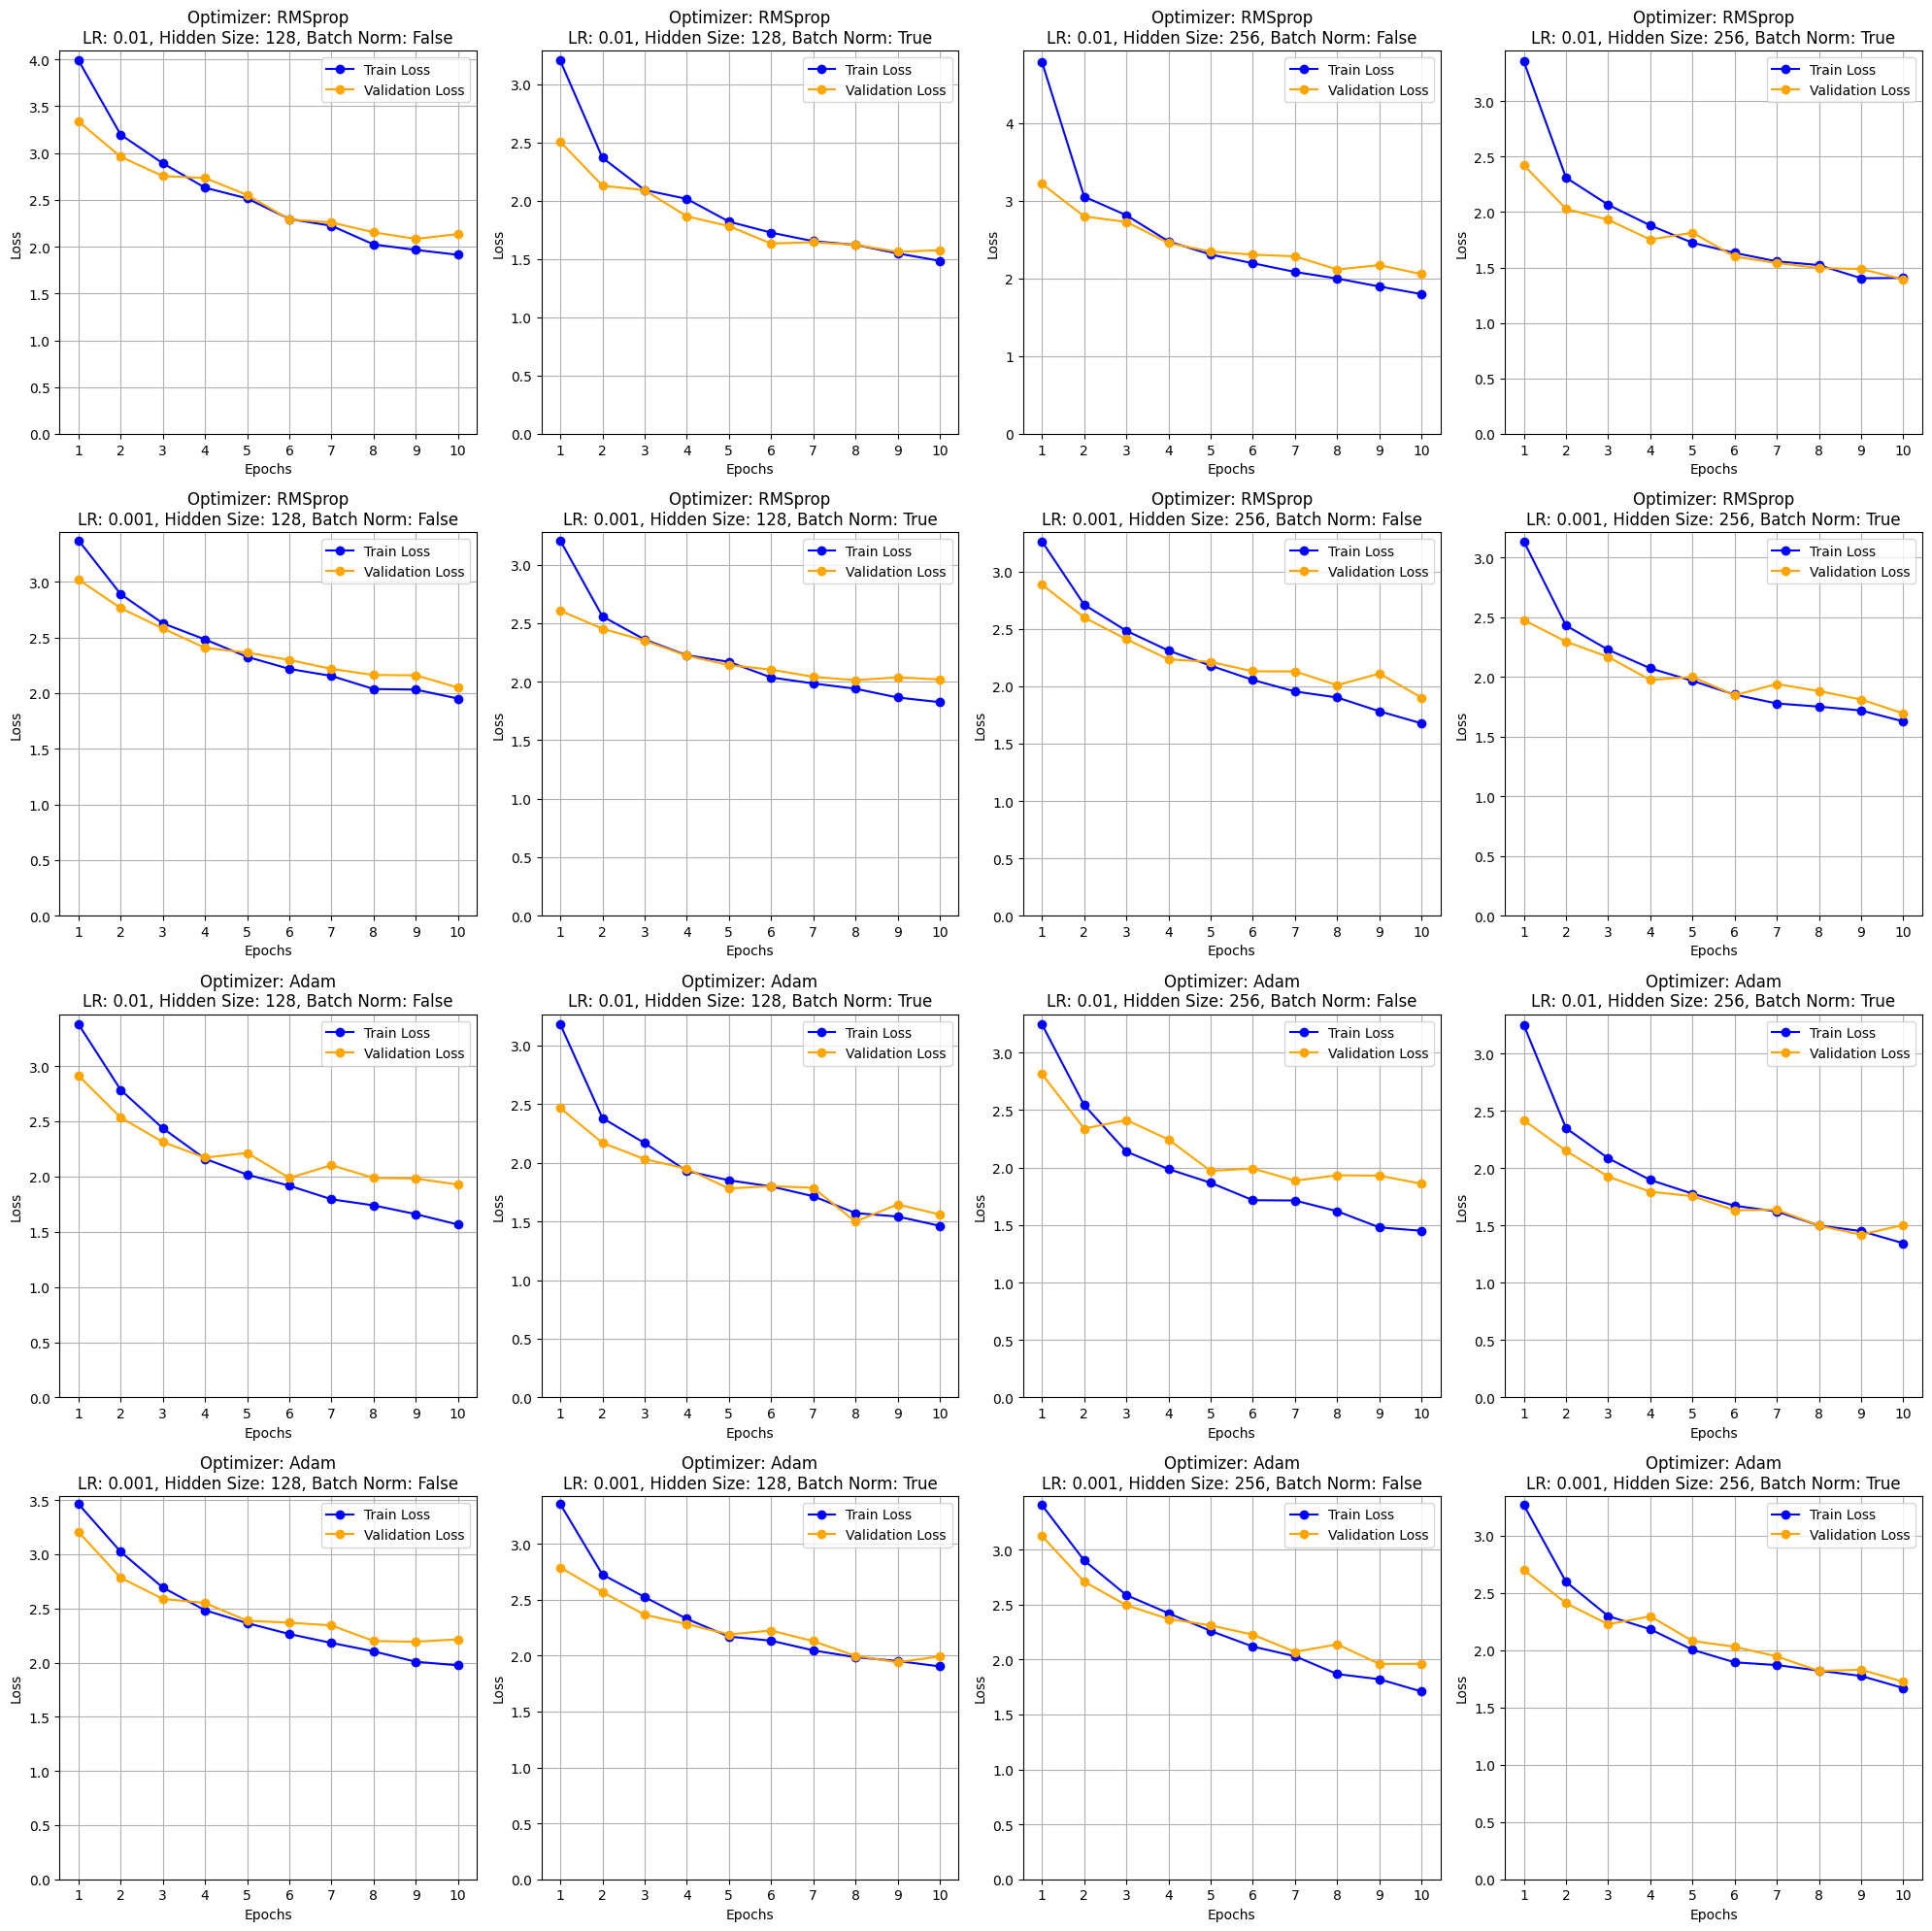

In [107]:
def plot_losses(results):
    num_results = len(results)
    num_rows = math.ceil(num_results / 4)

    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    axs = axs.flatten()

    for i, ((epochs, (optimizer_name, optimizer), lr, hidden_size, batch_norm), losses) in enumerate(results):
        train_loss = losses.get('train_loss', [])
        val_loss = losses.get('val_loss', [])

        epoch_range = range(1, epochs + 1)

        axs[i].plot(epoch_range, train_loss, label='Train Loss', color='blue', marker='o')
        axs[i].plot(epoch_range, val_loss, label='Validation Loss', color='orange', marker='o')

        axs[i].set_title(f'Optimizer: {optimizer_name}\nLR: {lr}, Hidden Size: {hidden_size}, Batch Norm: {batch_norm}')
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel('Loss')
        axs[i].set_ylim(bottom=0)
        axs[i].set_xticks(epoch_range)
        axs[i].legend()
        axs[i].grid()

    for j in range(i + 1, num_rows * 4):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_losses(res)

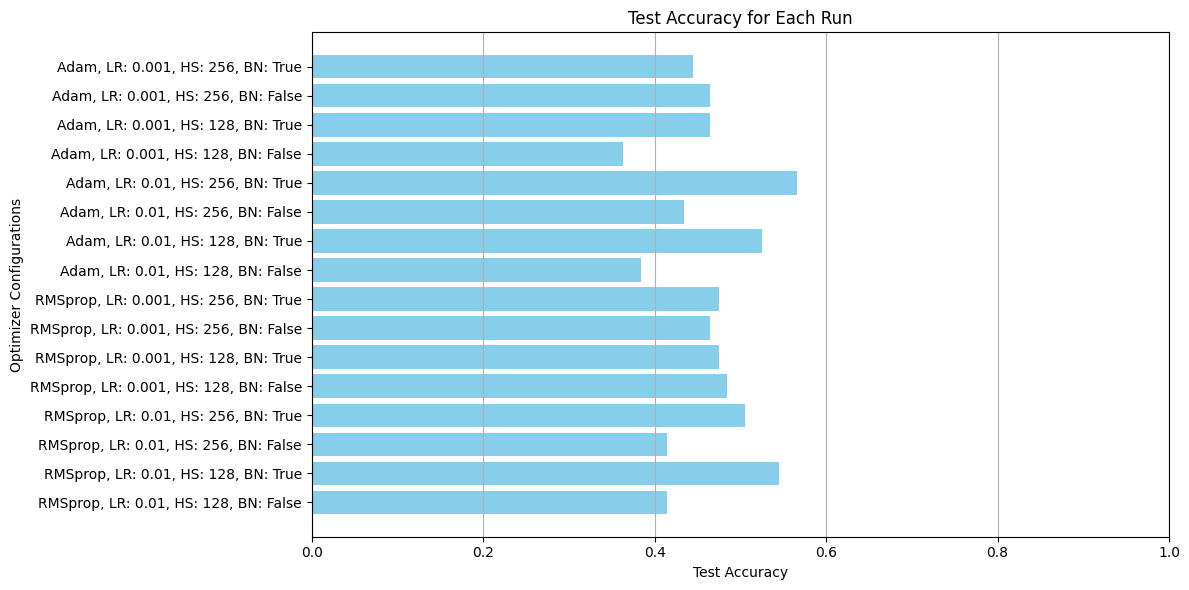

In [126]:
def plot_test_accuracy(results):
    optimizer_names = []
    test_accuracies = []

    for ((epochs, (optimizer_name, optimizer), lr, hidden_size, batch_norm), losses) in results:
        optimizer_names.append(f"{optimizer_name}, LR: {lr}, HS: {hidden_size}, BN: {batch_norm}")
        test_accuracies.append(losses['test_acc'])

    plt.figure(figsize=(12, 6))
    plt.barh(optimizer_names, test_accuracies, color='skyblue')

    plt.title('Test Accuracy for Each Run')
    plt.xlabel('Test Accuracy')
    plt.ylabel('Optimizer Configurations')
    plt.xlim(0, 1)
    plt.grid(axis='x')

    plt.tight_layout()
    plt.show()

plot_test_accuracy(res)

###

### Результаты
Лучше всего себя показал оптимизатор Adam с learning rate 0.01, размером скрытого слоя 256 и Batch Normalization.

Также неплохой результат показала модель с оптимизатором RMSprop, learning rate = 0.001, размером скрытого слоя 128 и Batch Normalization